In [2]:
import numpy as np
import scipy.signal as signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import tqdm as tqdm
import sys
import os
sys.path.insert(0, '/home/leo_dacasi/Dokumente/summerofcode/ENFify/sources')

from frequency_phase_estimation import phase_estimation_DFT0, phase_estimation_DFT1, instantaneous_freq

import soundfile as sf
from pydub import AudioSegment
from scipy.signal import hilbert
import math


In [31]:
def list_files_in_directory(directory):
    try:
        # List all files in the directory
        files = os.listdir(directory)
        # Filter out directories, only keep files
        raw_files = [f for f in files if os.path.isfile(os.path.join(directory, f))]
        down_files = []
        files = []

        for raw in raw_files:
            down_file = directory + '/down_'+raw
            down_files.append(down_file)
        
        for raw in raw_files:
            files.append(directory + '/' + raw)

        return files, down_files

    except FileNotFoundError:
        return f"The directory {directory} does not exist."
    except PermissionError:
        return f"Permission denied to access {directory}."


def downsampling(input_file, output_file, fs_down):
    os.system(f'. /home/$USER/miniforge3/etc/profile.d/conda.sh; conda activate enfify; ffmpeg -i {input_file} -ar {fs_down} {output_file}')
        

def bandpass_filter(sig,lowcut, highcut, fs, order):
    sos = signal.butter(order, [lowcut, highcut], btype='bandpass', output = 'sos', fs = fs )
    bandpass_sig = signal.sosfilt(sos, sig)
    return bandpass_sig

def hilbert_instantaneous_freq(signal, fs):
    analytic_sig = hilbert(signal)
    inst_phase  = np.unwrap(np.angle(analytic_sig))
    inst_freq = (np.diff(inst_phase)/(2.0*np.pi) * fs)
    return max(inst_freq)

def segmented_freq_estimation_DFT1(s_in, f_s, num_cycles, N_DFT, nominal_enf):
    step_size = int(f_s // nominal_enf)  # samples per nominal enf cycle

    num_blocks = len(s_in) // step_size - (num_cycles - 1)

    segments = [s_in[i * step_size : (i + num_cycles) * step_size] for i in range(num_blocks)]

    freqs = []
    for i in range(len(segments)):
        freq,_ = phase_estimation_DFT1(segments[i], f_s, N_DFT)
        freqs.append(freq)

    freqs = np.array(freqs)
    
    return freqs

def freq_estimation(sig, fs):

    nperseg = 10 *fs
    freqs,times,stft = signal.stft(sig, fs=fs, nperseg=nperseg) # Apply STFT
    peak_freqs = [freqs[idx] for t in range(len(times)) if (idx := np.argmax(stft[:,t]))] # Extract peak for each point in time

    return peak_freqs

def VariationalModeDecomposition(signal, alpha, tau, num_modes, enforce_DC, tolerance):
    
    # Mirror signal at boundaries
    if len(signal) % 2:
        midpoint = math.ceil(len(signal) / 2)
        left_mirror = np.concatenate((np.flipud(signal[:midpoint-1]), signal), axis=0)
        mirrored_signal = np.concatenate((left_mirror, np.flipud(signal[midpoint:])), axis=0)
    else:
        midpoint = len(signal) // 2
        left_mirror = np.concatenate((np.flipud(signal[:midpoint]), signal), axis=0)
        mirrored_signal = np.concatenate((left_mirror, np.flipud(signal[midpoint:])), axis=0)
    
    # Define time and frequency domains
    total_length = len(mirrored_signal)
    time_domain = np.arange(1, total_length + 1) / total_length
    spectral_domain = time_domain - 0.5 - (1 / total_length)

    # Iteration parameters
    max_iterations = 500
    mode_alphas = alpha * np.ones(num_modes)
    
    # FFT of the mirrored signal and preparation for iterations
    signal_spectrum = np.fft.fftshift(np.fft.fft(mirrored_signal))
    positive_spectrum = np.copy(signal_spectrum)
    positive_spectrum[:total_length // 2] = 0

    # Initialize frequency center estimates
    freq_centers = np.zeros((max_iterations, num_modes))
    for mode in range(num_modes):
        freq_centers[0, mode] = (0.5 / num_modes) * mode

    # Enforce DC mode if required
    if enforce_DC:
        freq_centers[0, 0] = 0

    # Initialize dual variables and other parameters
    dual_vars = np.zeros((max_iterations, len(spectral_domain)), dtype=complex)
    convergence_criteria = tolerance + np.spacing(1)
    iteration_count = 0
    mode_sum = 0
    mode_spectra = np.zeros((max_iterations, len(spectral_domain), num_modes), dtype=complex)

    # Main iterative update loop
    while (convergence_criteria > tolerance and iteration_count < max_iterations - 1):
        mode_sum = mode_spectra[iteration_count, :, num_modes - 1] + mode_sum - mode_spectra[iteration_count, :, 0]
        
        mode_spectra[iteration_count + 1, :, 0] = (positive_spectrum - mode_sum - dual_vars[iteration_count, :] / 2) / \
                                                  (1 + mode_alphas[0] * (spectral_domain - freq_centers[iteration_count, 0]) ** 2)
        
        if not enforce_DC:
            freq_centers[iteration_count + 1, 0] = np.dot(spectral_domain[total_length // 2:],
                                                          abs(mode_spectra[iteration_count + 1, total_length // 2:, 0]) ** 2) / \
                                                   np.sum(abs(mode_spectra[iteration_count + 1, total_length // 2:, 0]) ** 2)

        for mode in range(1, num_modes):
            mode_sum = mode_spectra[iteration_count + 1, :, mode - 1] + mode_sum - mode_spectra[iteration_count, :, mode]
            mode_spectra[iteration_count + 1, :, mode] = (positive_spectrum - mode_sum - dual_vars[iteration_count, :] / 2) / \
                                                         (1 + mode_alphas[mode] * (spectral_domain - freq_centers[iteration_count, mode]) ** 2)
            freq_centers[iteration_count + 1, mode] = np.dot(spectral_domain[total_length // 2:],
                                                             abs(mode_spectra[iteration_count + 1, total_length // 2:, mode]) ** 2) / \
                                                      np.sum(abs(mode_spectra[iteration_count + 1, total_length // 2:, mode]) ** 2)

        dual_vars[iteration_count + 1, :] = dual_vars[iteration_count, :] + tau * (np.sum(mode_spectra[iteration_count + 1, :, :], axis=1) - positive_spectrum)
        
        iteration_count += 1
        
        convergence_criteria = np.spacing(1)
        for mode in range(num_modes):
            convergence_criteria += (1 / total_length) * np.dot((mode_spectra[iteration_count, :, mode] - mode_spectra[iteration_count - 1, :, mode]),
                                                               np.conj(mode_spectra[iteration_count, :, mode] - mode_spectra[iteration_count - 1, :, mode]))

        convergence_criteria = np.abs(convergence_criteria)

    # Postprocessing to extract modes and their spectra
    max_iterations = min(max_iterations, iteration_count)
    final_freq_centers = freq_centers[:max_iterations, :]
    
    half_idxs = np.flip(np.arange(1, total_length // 2 + 1), axis=0)
    final_mode_spectra = np.zeros((total_length, num_modes), dtype=complex)
    final_mode_spectra[total_length // 2:total_length, :] = mode_spectra[max_iterations - 1, total_length // 2:total_length, :]
    final_mode_spectra[half_idxs, :] = np.conj(mode_spectra[max_iterations - 1, total_length // 2:total_length, :])
    final_mode_spectra[0, :] = np.conj(final_mode_spectra[-1, :])

    modes = np.zeros((num_modes, len(time_domain)))
    for mode in range(num_modes):
        modes[mode, :] = np.real(np.fft.ifft(np.fft.ifftshift(final_mode_spectra[:, mode])))
    
    modes = modes[:, total_length // 4: 3 * total_length // 4]

    mode_spectra_final = np.zeros((modes.shape[1], num_modes), dtype=complex)
    for mode in range(num_modes):
        mode_spectra_final[:, mode] = np.fft.fftshift(np.fft.fft(modes[mode, :]))

    return modes, mode_spectra_final, final_freq_centers

3861649


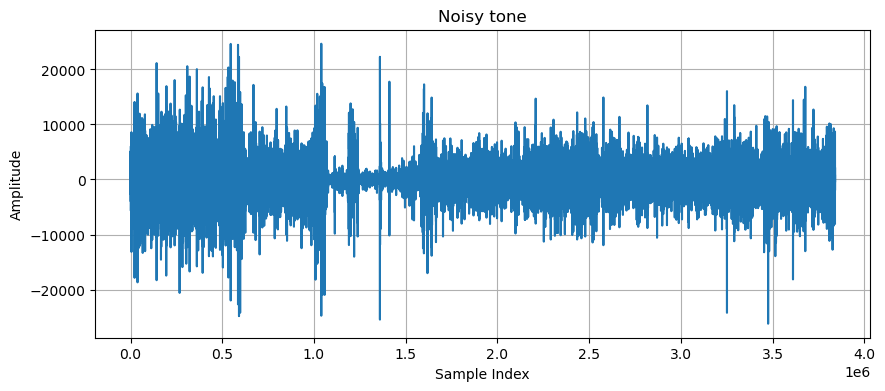

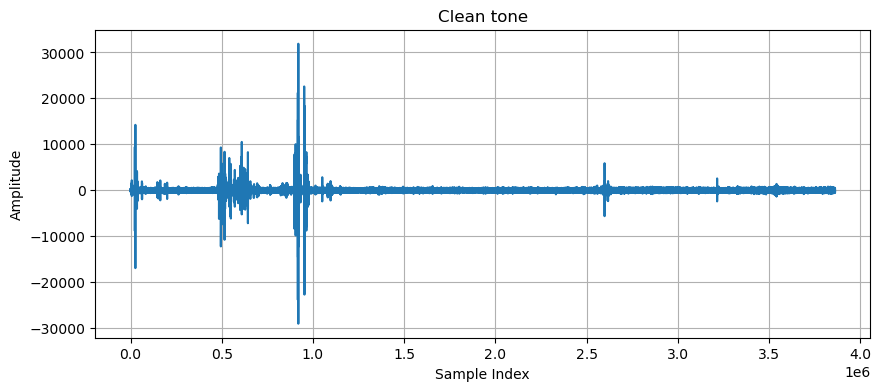

In [4]:
noise_fs, noise_data = wavfile.read('Wuhan_ENF_data/01.wav')
clean_fs, clean_data = wavfile.read('Wuhan_ENF_data/001.wav')

n_noise = np.arange(len(noise_data))
n_clean = np.arange(len(clean_data))

print(len(clean_data))

plt.figure(figsize=(10, 4))
plt.plot(n_noise, noise_data)
plt.title('Noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(n_clean, clean_data)
plt.title('Clean tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [22]:
dir = 'Wuhan_ENF_data'
rawFile_name, downFile_name = list_files_in_directory(dir)


for i in range(len(rawFile_name)):
    downsampling(rawFile_name[i], downFile_name[i], fs_down = 1000)

Wuhan_ENF_data/down_01.wav


ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-13)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-lib

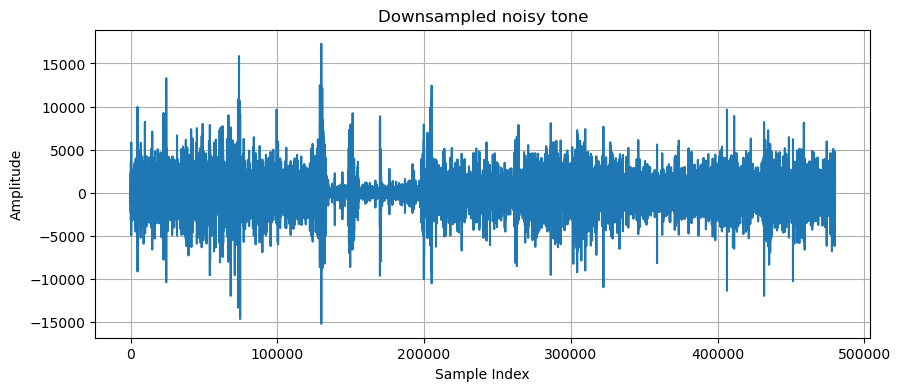

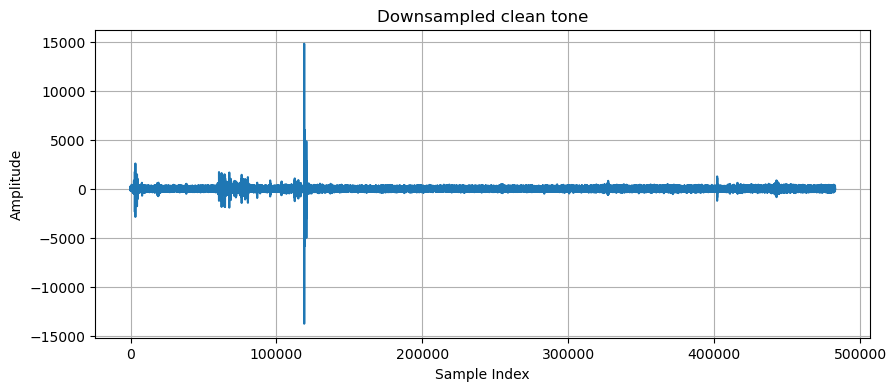

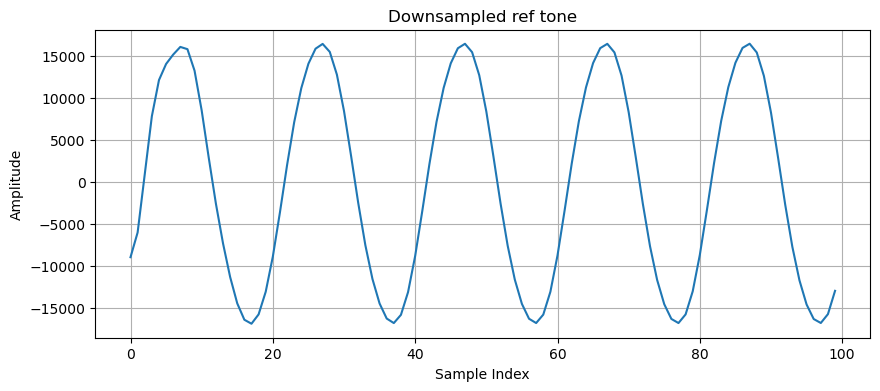

In [47]:
noise_fs, down_sig_noise = wavfile.read('Wuhan_ENF_data/down_01.wav')
clean_fs, down_sig_clean = wavfile.read('Wuhan_ENF_data/down_001.wav')
ref_fs, down_sig_ref = wavfile.read('Wuhan_ENF_data/down_001_ref.wav')

n_noise = np.arange(len(down_sig_noise))
n_clean = np.arange(len(down_sig_clean))
n_ref = np.arange(len(down_sig_ref))

#print(clean_fs)

plt.figure(figsize=(10, 4))
plt.plot(n_noise, down_sig_noise)
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(n_clean, down_sig_clean)
plt.title('Downsampled clean tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(n_ref[:100], down_sig_ref[:100])
plt.title('Downsampled ref tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

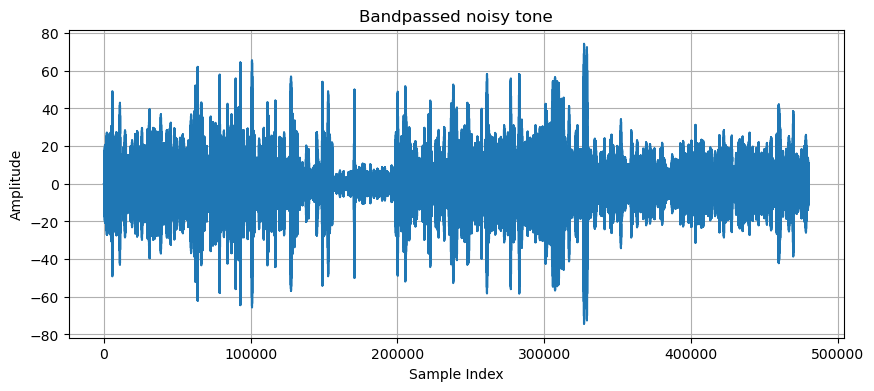

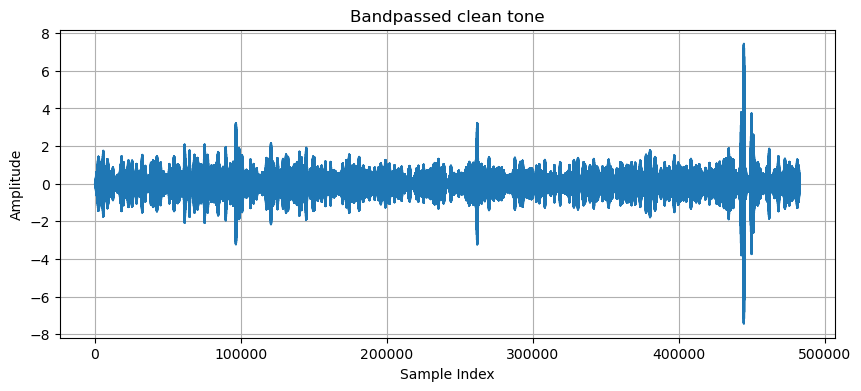

In [48]:
bandpass_noise = bandpass_filter(down_sig_noise, 49, 51, 1000, 4)
n_noise = np.arange(len(bandpass_noise))

plt.figure(figsize=(10, 4))
plt.plot(n_noise, bandpass_noise)
plt.title('Bandpassed noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

bandpass_clean = bandpass_filter(down_sig_clean, 49.5, 50.5, 1000, 4)
n_clean = np.arange(len(bandpass_clean))

plt.figure(figsize=(10, 4))
plt.plot(n_clean, bandpass_clean)
plt.title('Bandpassed clean tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig("Bandpassed_clean_signal")
plt.show()


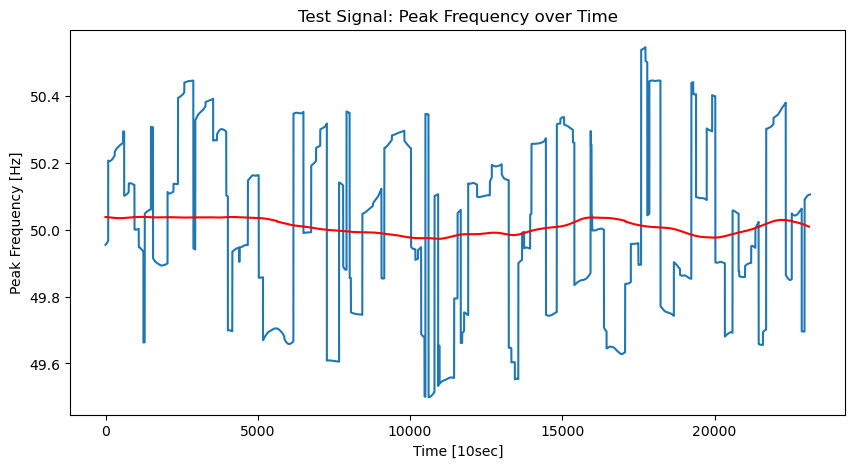

In [35]:
# Reference signal
ref_fs, down_sig_ref = wavfile.read('Wuhan_ENF_data/down_001_ref.wav')
bandpass_ref = bandpass_filter(down_sig_ref, 49.5, 50.5, 1000, 4)
#peak_freqs_ref = freq_estimation(bandpass_ref, ref_fs)
peak_freqs_ref = segmented_freq_estimation_DFT1(bandpass_ref, clean_fs, num_cycles = 1000, N_DFT= 20_000, nominal_enf=50)

#peak_freqs = freq_estimation(bandpass_clean, clean_fs)
peak_freqs_band = segmented_freq_estimation_DFT1(bandpass_clean, clean_fs, num_cycles = 1000, N_DFT= 20_000, nominal_enf=50)

# Plot the peak frequency extracted from the test signal
plt.figure(figsize=(10,5))
plt.plot(peak_freqs_band)
plt.plot(peak_freqs_ref, color='red')
plt.ylabel('Peak Frequency [Hz]')
plt.xlabel('Time')
plt.title("Test Signal: Peak Frequency over Time")
plt.show()


In [ ]:
alpha = 20000000 # moderate bandwidth constraint
tau = 0 
n_mode = 1
DC = 0  # no DC part imposed  
tol = 1e-12

u_clean, u_hat_clean, omega_clean = VariationalModeDecomposition(bandpass_clean, alpha, tau, n_mode, DC, tol)

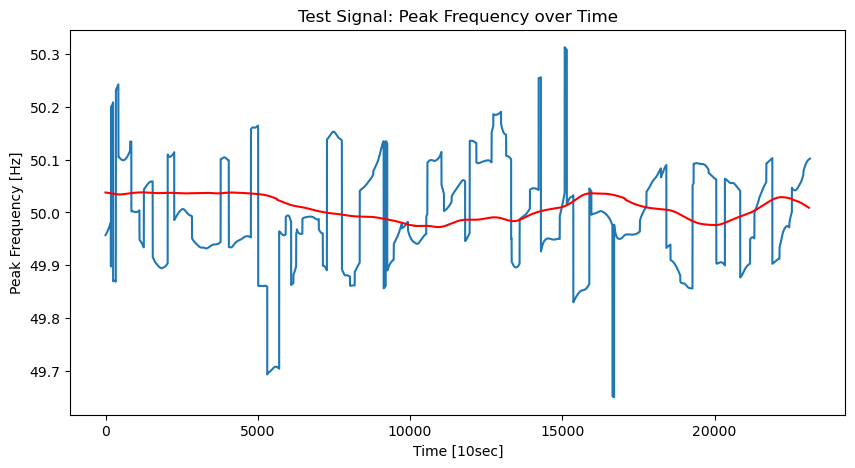

In [38]:
peak_freqs_vmd = segmented_freq_estimation_DFT1(u_clean[0], clean_fs, num_cycles = 1000, N_DFT= 20_000, nominal_enf=50)

# Plot the peak frequency extracted from the test signal
plt.figure(figsize=(10,5))
plt.plot(peak_freqs_vmd)
plt.plot(peak_freqs_ref, color='red')
plt.ylabel('Peak Frequency [Hz]')
plt.xlabel('Time')
plt.title("Test Signal: Peak Frequency over Time")
plt.show()


In [ ]:
peak_freqs = segmented_freq_estimation_DFT1(bandpass_noise, noise_fs, num_cycles = 1000, N_DFT= 20_000, nominal_enf=50)

# Plot the peak frequency extracted from the test signal
plt.figure(figsize=(10,5))
plt.plot(peak_freqs)
plt.plot(peak_freqs_ref, color='red')
plt.ylabel('Peak Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Test Signal: Peak Frequency over Time")
plt.plot

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

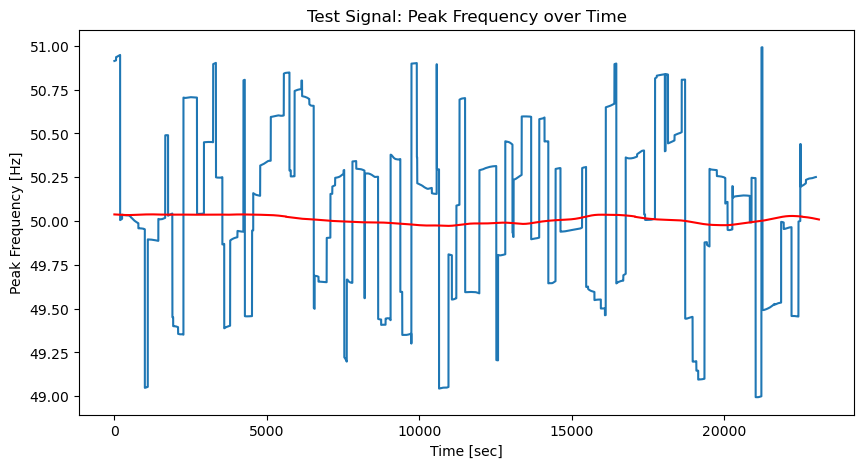

In [40]:
alpha = 2000 # moderate bandwidth constraint
tau = 0 
n_mode = 1
DC = 0  # no DC part imposed  
tol = 1e-7

u_noise, u_hat_noise, omega_noise = VariationalModeDecomposition(bandpass_noise, alpha, tau, n_mode, DC, tol)
freqs_vmd_noise = segmented_freq_estimation_DFT1(u_noise[0], clean_fs, num_cycles = 1000, N_DFT= 20_000, nominal_enf=50)

# Plot the peak frequency extracted from the test signal
plt.figure(figsize=(10,5))
plt.plot(freqs_vmd_noise)
plt.plot(peak_freqs_ref, color='red')
plt.ylabel('Peak Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Test Signal: Peak Frequency over Time")
plt.plot

In [42]:
dir = 'Talkbank_data'
rawFile_name, downFile_name = list_files_in_directory(dir)
for i in range(len(rawFile_name)):
    downsampling(rawFile_name[i], downFile_name[i], fs_down = 1000)

ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-13)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-lib

1000
[  6.  -21.5 -34.5 ...  -5.   -4.   -5.5]


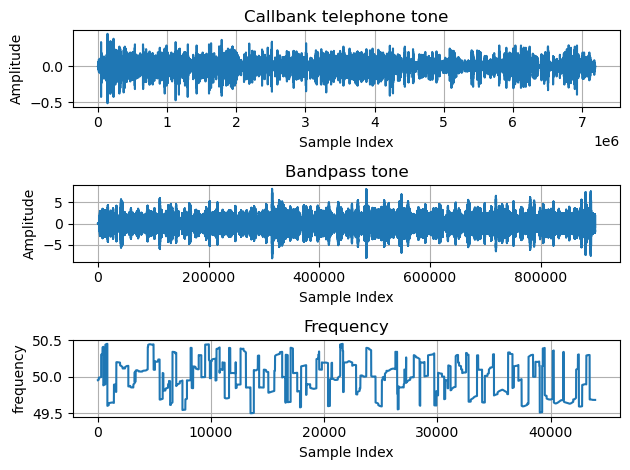

In [46]:
###.........................Talk_bank......................###

noise_data, noise_fs = sf.read('Talkbank_data/1082.wav')
noise_data = np.mean(noise_data, axis=1)
n_noise = np.arange(len(noise_data))

plt.figure()
plt.subplot(3,1,1)
plt.plot(n_noise, noise_data)
plt.title('Callbank telephone tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()


talkbank_fs, down_sig_talkbank = wavfile.read('Talkbank_data/down_1082.wav')
down_sig_talkbank = np.mean(down_sig_talkbank, axis=1)
bandpass_talkbank = bandpass_filter(down_sig_talkbank, 49.5, 50.5, talkbank_fs, 4)
n_talkbank = np.arange(len(bandpass_talkbank))

print(talkbank_fs)
print(down_sig_talkbank)

plt.subplot(3,1,2)
plt.plot(n_talkbank, bandpass_talkbank)
plt.title('Bandpass tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()

inst_freq_talkbank = segmented_freq_estimation_DFT1(bandpass_talkbank, talkbank_fs, num_cycles = 1000, N_DFT= 20_000, nominal_enf=50)

plt.subplot(3,1,3)
plt.plot(inst_freq_talkbank)
plt.title('Frequency')
plt.xlabel('Sample Index')
plt.ylabel('frequency')
plt.grid()
plt.tight_layout()


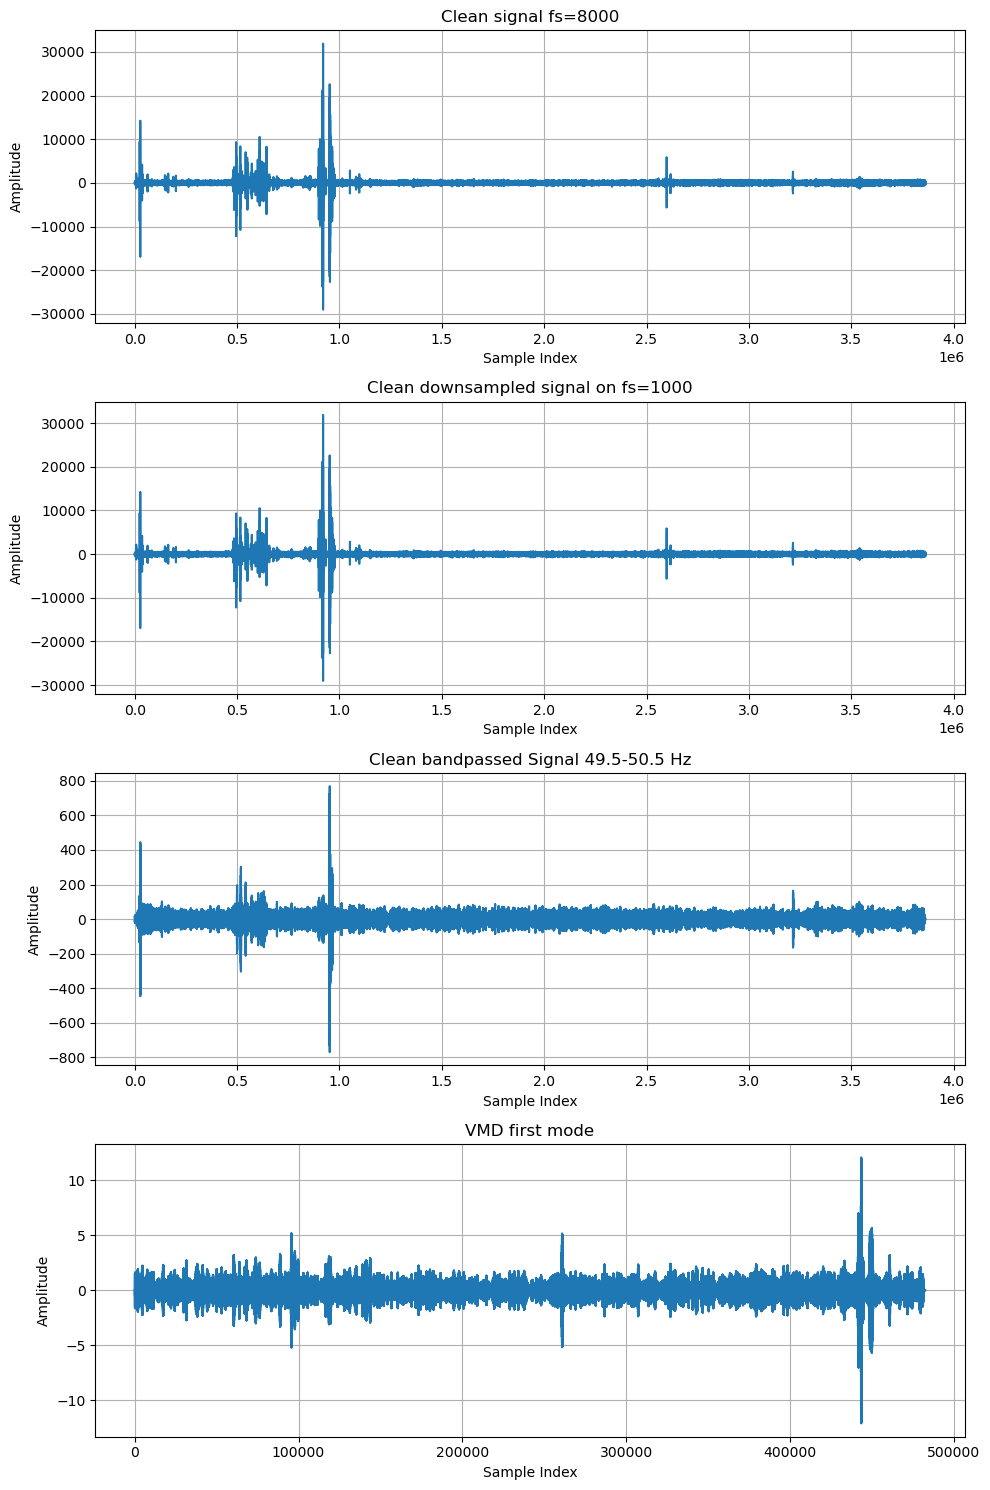

In [13]:
### Clean plot
_, clean_data = wavfile.read('Wuhan_ENF_data/001.wav')
n_clean = np.arange(len(clean_data ))

clean_fs, downsampled_clean = wavfile.read('Wuhan_ENF_data/001.wav')
n_clean_down = np.arange(len(downsampled_clean))

bandpass_clean = bandpass_filter(downsampled_clean, 49.5, 50.5, 1000, 4)
n_clean_band = np.arange(len(bandpass_clean))

vmd = u[0]
n_vmd = np.arange(len(u[0]))

plt.figure(figsize=(10, 15))

plt.subplot(4,1,1)
plt.plot(n_clean, clean_data)
plt.title('Clean signal fs=8000')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()

plt.subplot(4,1,2)
plt.plot(n_clean_down, downsampled_clean)
plt.title('Clean downsampled signal on fs=1000')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()

plt.subplot(4,1,3)
plt.plot(n_clean_band , bandpass_clean)
plt.title('Clean bandpassed Signal 49.5-50.5 Hz')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()

plt.subplot(4,1,4)
plt.plot(n_vmd, vmd)
plt.title('VMD first mode')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()
#plt.savefig("clean_signal_amplitude")

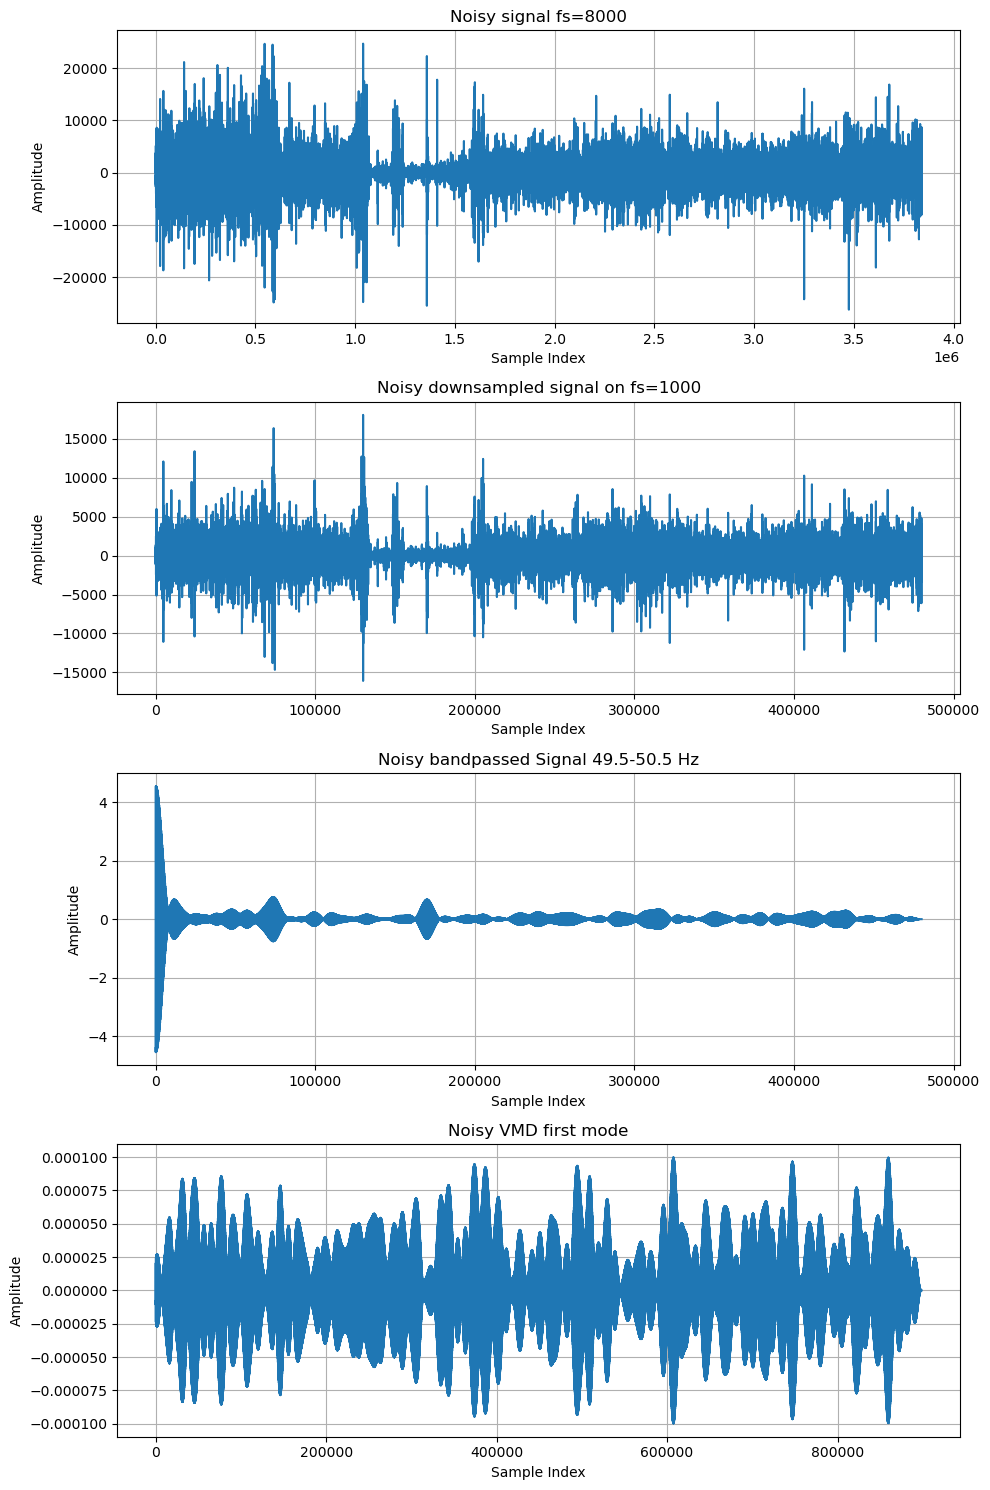

In [91]:
### Clean plot
clean_fs, clean_data = wavfile.read('Wuhan_ENF_data/01.wav')
n_clean = np.arange(len(clean_data))

downsampled_clean = downsampling(clean_data, clean_fs, f_ds=1000)
n_clean_down = np.arange(len(downsampled_clean))

bandpass_clean = bandpass_filter(downsampled_clean, 49.5, 50.5, 8000, 3)
n_clean_band = np.arange(len(bandpass_clean))

vmd = u_noise[0]
n_vmd = np.arange(len(u_noise[0]))

plt.figure(figsize=(10, 15))

plt.subplot(4,1,1)
plt.plot(n_clean, clean_data)
plt.title('Noisy signal fs=8000')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()

plt.subplot(4,1,2)
plt.plot(n_clean_down, downsampled_clean)
plt.title('Noisy downsampled signal on fs=1000')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()

plt.subplot(4,1,3)
plt.plot(n_clean_band , bandpass_clean)
plt.title('Noisy bandpassed Signal 49.5-50.5 Hz')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()

plt.subplot(4,1,4)
plt.plot(n_vmd, vmd)
plt.title('Noisy VMD first mode')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()
#plt.savefig("noisy_signal_amplitude")